In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()

In [277]:
pd.options.display.max_columns = 500

In [278]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

In [279]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [280]:
train.shape

(30471, 292)

# Домашнее задание №1

Ваша задача изучить как различные преобразования влияют на модель и итоговый результат. 

1) Для удобства написать функцию, которая реализовала бы кросс-валидацию. Данная функция принимает на вход данные и другие аргументы на выше усмотрение, на выходе скор на кроссвалидации и его стандартное отклонение.

2) Сделать несколько различных моделей с различными признаками и способами обработки признаков.

    1. Например в первой модели будут использованы  непрерывные признаки   ['metro_km_walk', 'kremlin_km', 'full_sq'] с заполненными пропусками
    
    2. Во второй модели нормируйте признаки из первой модели (std=1, mean = 0). Изменился ли результат? 
    
    3. Во второй модели добавлены преобразованные различным образом категориальне признаки ['product_type' , 'sub_area' ] и т.д.
    
    4. В третьей добавлены datetime признаки 
    
    5. И так далее. Попробуйте реализовать различные гипотезы

3) Для каждой модели нужно сделать кросс-валидацию и засабмитить предсказание на тестовой выборке на кагл

4) Построить график зависимости Leader board score от score на кросс-валидации для всех 5 моделей. 

5) Написать отчет с выводами. 



P.S. Не забудьте про то, что вы можете делать модель для предсказания price_m2, а итоговый результат подсчитывается по price_doc

P.P.S.  Все преобразования, которые вы делаете нужно проделывать и с тестовой выборкой!

P.P.P.S. Можно использовать готовые функции и преобразования из sklearn.

In [281]:
columns = train.apply(lambda x: sum(x.isnull()), axis=0)
columns[columns > 0] 

life_sq                                   6383
floor                                      167
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
preschool_quota                           6688
school_quota                              6685
hospital_beds_raion                      14441
raion_build_count_with_material_info      4991
build_count_block                         4991
build_count_wood                          4991
build_count_frame                         4991
build_count_brick                         4991
build_count_monolith                      4991
build_count_panel                         4991
build_count_foam                          4991
build_count_slag                          4991
build_count_mix                           4991
raion_build_c

In [282]:
train.dtypes

id                      int64
timestamp              object
full_sq                 int64
life_sq               float64
floor                 float64
                       ...   
mosque_count_5000       int64
leisure_count_5000      int64
sport_count_5000        int64
market_count_5000       int64
price_doc               int64
Length: 292, dtype: object

## Функция для кроссвалидации

In [283]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from collections import namedtuple

In [284]:
def cross_validate_score(data, features, target):
    mse_list = []
    msle_list = []
    rmsle_list = []

    kf = KFold(n_splits=5, shuffle=True)

    for i, (train_index, val_index) in enumerate(kf.split(data)):
        train_part = data.loc[train_index, :]
        val_part = data.loc[val_index, :]

        model = SGDRegressor()
        model.fit(X=train_part[features], y=train_part[target])
        val_prediction = model.predict(val_part[features]).clip(0, 1000000000)

        mse = mean_squared_error(val_prediction, val_part[target])
        mse_list.append(mse)
        
        msle = mean_squared_log_error(val_prediction, val_part[target])
        msle_list.append(msle)

        rmsle = math.sqrt(msle)
        rmsle_list.append(rmsle)

    Score = namedtuple('Score', ['mse_average', 'rmsle_average', 'msle_average', 'msle_std'])
        
    return Score(np.mean(mse_list), np.mean(rmsle_list), np.mean(msle_list), np.std(msle_list))

## Строим модели и валидируем

### Первая модель
В первой модели будут использованы  непрерывные признаки   ['metro_km_walk', 'kremlin_km', 'full_sq'] с заполненными пропусками.

In [298]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

train_data_1 = train.copy()
train_data_1[features] = train_data_1[features].fillna(0)

test_data_1 = test.copy()
test_data_1 = test_data_1[features].fillna(0)

test_data_1

model1 = SGDRegressor()
model1.fit(X=train_data_1[features], y=train_data_1[target])

sample_submission[target] = model1.predict(test_data_1).clip(0, 1000000000)
sample_submission.to_csv('predict_1.csv', index=False)

In [286]:
cross_score_1 = cross_validate_score(train_data_1, features, target).rmsle_average
kaggle_score_1 = 0.64143

print('Model 1 (\'metro_km_walk\', \'kremlin_km\', \'full_sq\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_1, kaggle_score_1))

Model 1 ('metro_km_walk', 'kremlin_km', 'full_sq')
Cross-validation: 6.883410408686187
Kaggle: 0.64143


### Вторая модель
Во второй модели будут использованы нормированные непрерывные признаки ['metro_km_walk', 'kremlin_km', 'full_sq'] с заполненными пропусками.

In [287]:
from sklearn import preprocessing

In [288]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

mm_scaler = preprocessing.MinMaxScaler() # [0, 1]

train_data_2 = train.copy()
train_data_2[features] = mm_scaler.fit_transform(train_data_2[features].fillna(0))

test_data_2 = test.copy()
test_data_2[features] = mm_scaler.fit_transform(test_data_2[features].fillna(0))

model2 = SGDRegressor()
model2.fit(X=train_data_2[features], y=train_data_2[target])

sample_submission[target] = model2.predict(test_data_2[features]).clip(0, 1000000000)
sample_submission.to_csv('predict_2.csv', index=False)

In [289]:
cross_score_2 = cross_validate_score(train_data_2, features, target).rmsle_average
kaggle_score_2 = 0.60980

print('Model 2 (\'metro_km_walk\', \'kremlin_km\', \'full_sq\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_2, kaggle_score_2))

Model 2 ('metro_km_walk', 'kremlin_km', 'full_sq')
Cross-validation: 0.6084374080249633
Kaggle: 0.6098


### Третья модель
В третьей модели к второй модели добавлены преобразованные различным образом категориальные признаки ['product_type' , 'sub_area'].

In [290]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq', 'product_type' , 'sub_area']
target = 'price_doc'

train_data_3 = train_data_2.copy()
train_data_3['price_m2'] = train_data_3['price_doc']/ (train_data_3['full_sq']+1)
train_data_3['price_m2'].clip(train_data_3['price_m2'].quantile(0.01), train_data_3['price_m2'].quantile(0.99), inplace=True)
train_data_3['product_type'] = train_data_3['product_type'].replace({'Investment':1,'OwnerOccupier':0})

sub_area_target_encoding = train_data_3.groupby(['sub_area'])['price_m2'].mean()
train_data_3['sub_area'] = train_data_3['sub_area'].replace(sub_area_target_encoding)

test_data_3 = test_data_2.copy()
test_data_3['product_type'] = test_data_3['product_type'].fillna(0).replace({'Investment':1,'OwnerOccupier':0})
test_data_3['sub_area'] = test_data_3['sub_area'].replace(sub_area_target_encoding)

model3 = SGDRegressor()
model3.fit(X=train_data_3[features], y=train_data_3[target])

sample_submission[target] = model3.predict(test_data_3[features]).clip(0, 1000000000)
sample_submission.to_csv('predict_3.csv', index=False)

In [291]:
cross_score_3 = cross_validate_score(train_data_3, features, target).rmsle_average
kaggle_score_3 = 5.04376

print('Model 3 (\'metro_km_walk\', \'kremlin_km\', \'full_sq\', \'product_type\' , \'sub_area\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_3, kaggle_score_3))

Model 3 ('metro_km_walk', 'kremlin_km', 'full_sq', 'product_type' , 'sub_area')
Cross-validation: 9.336901327062128
Kaggle: 5.04376


### Четвёртая модель
В чётвертой модели к третьей модели добавлен datetime признак ['timestamp'].

In [292]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    timestamp_series = pd.to_datetime(timestamp_series,format='%Y-%m-%d')

    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000 

    return output

In [293]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq', 'product_type' , 'sub_area', 'month', 'day_week', 'day_month_datetime', 'year', 'seconds']
target = 'price_doc'

train_data_4 = train_data_3.copy()
train_data_4 = pd.concat([train_data_4, get_date_time_features(train_data_4['timestamp'])], axis=1)
train_data_4

test_data_4 = test_data_3.copy()
test_data_4 = pd.concat([test_data_4, get_date_time_features(test_data_4['timestamp'])], axis=1)

model4 = SGDRegressor()
model4.fit(X=train_data_4[features], y=train_data_4[target])

sample_submission[target] = model4.predict(test_data_4[features]).clip(0, 1000000000)
sample_submission.to_csv('predict_4.csv', index=False)

/var/folders/9k/n4yjmb4j2y141ms03qrz3q680000gn/T/ipykernel_39086/2011329045.py:10: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000


In [294]:
cross_score_4 = cross_validate_score(train_data_4, features, target).rmsle_average
kaggle_score_4 = 10.70268

print('Model 4 (\'metro_km_walk\', \'kremlin_km\', \'full_sq\', \'product_type\' , \'sub_area\', \'timestamp\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_4, kaggle_score_4))

Model 4 ('metro_km_walk', 'kremlin_km', 'full_sq', 'product_type' , 'sub_area', 'timestamp')
Cross-validation: 9.33683948171837
Kaggle: 10.70268


### Пятая модель
В пятой модели к четвертой модели добавлен признак ['green_zone_part'].

In [295]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq', 'product_type' , 'sub_area', 'month', 'day_week', 'day_month_datetime', 'year', 'seconds', 'green_zone_part']
target = 'price_doc'

train_data_5 = train_data_4.copy()
test_data_5 = test_data_4.copy()

model5 = SGDRegressor()
model5.fit(X=train_data_5[features], y=train_data_5[target])

sample_submission[target] = model5.predict(test_data_5[features]).clip(0, 1000000000)
sample_submission.to_csv('predict_5.csv', index=False)

In [296]:
cross_score_5 = cross_validate_score(train_data_5, features, target).rmsle_average
kaggle_score_5 = 6.29437

print('Model 5 (\'metro_km_walk\', \'kremlin_km\', \'full_sq\', \'product_type\' , \'sub_area\', \'timestamp\', \'green_zone_part\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_5, kaggle_score_5))

Model 5 ('metro_km_walk', 'kremlin_km', 'full_sq', 'product_type' , 'sub_area', 'timestamp', 'green_zone_part')
Cross-validation: 11.433966248700564
Kaggle: 6.29437


## Сравнение и график

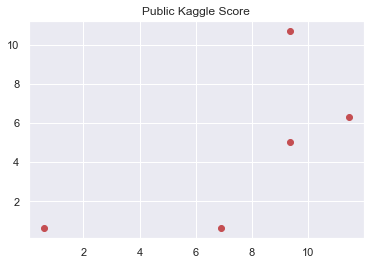

In [297]:
x = [cross_score_1, cross_score_2, cross_score_3, cross_score_4, cross_score_5]
y = [kaggle_score_1, kaggle_score_2, kaggle_score_3, kaggle_score_4, kaggle_score_5]

plt.title('Public Kaggle Score')
plt.plot(x, y, 'ro')
plt.show()

В качестве выводов наверное логично сказать, что с ростом score кросс-валидации растет значение score на Kaggle и в принципе это видно по графику. 